In [1]:
1+2

3

In [2]:
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline


# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')
from functions.save_array_to_disk import *
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as track

# set variables =============================================
# ===========================================================

axis = 'X'


clim_min, clim_max = -0.03, 0

xController = pc.MDT693A('X')

363.8283426


In [3]:
def acquire_roi_and_show(roi, title =''):

    xVmin,xVmax,xPts,yVmin,yVmax,yPts = track.roi_to_galvoparameter(roi)
    # acquire data
    scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)
    image_data = scanner.scan()

    X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

    # plot image
    fig = plt.figure()

    p = plt.pcolor(X, Y, image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)
    plt.xlim([xVmin, xVmax])
    plt.ylim([yVmin, yVmax])
    plt.title(title)
    plt.show()
    
    return image_data

# scan z  - no compensation for drifts

voltage 40.0V


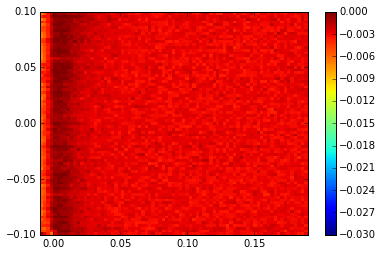

voltage 42.0V


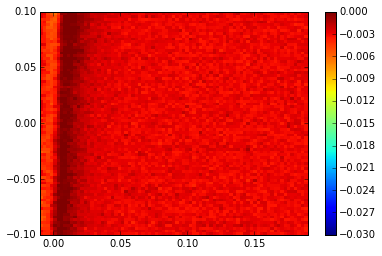

voltage 44.0V


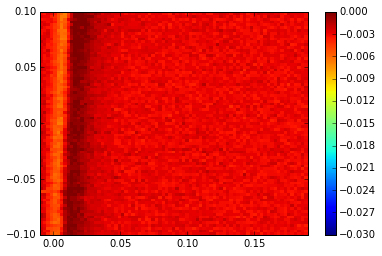

voltage 46.0V


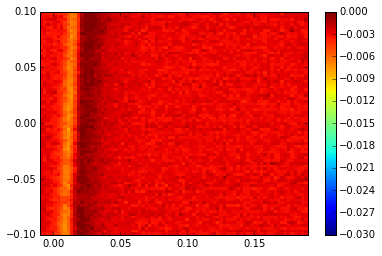

voltage 48.0V


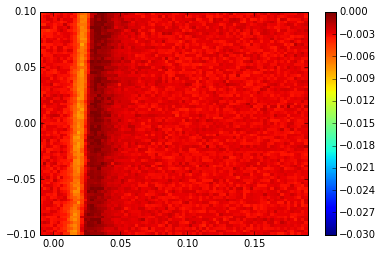

voltage 50.0V


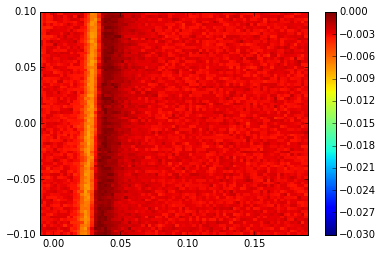

voltage 52.0V


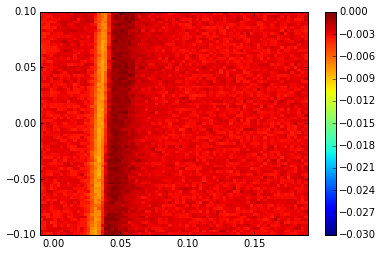

voltage 54.0V


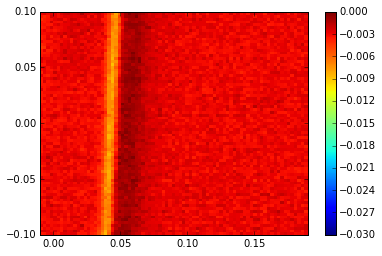

voltage 56.0V


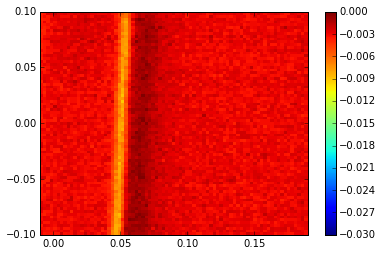

voltage 58.0V


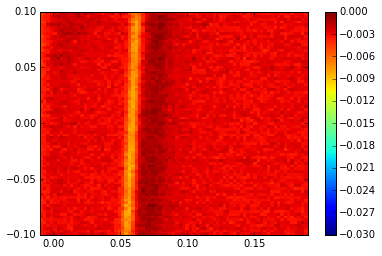

voltage 60.0V


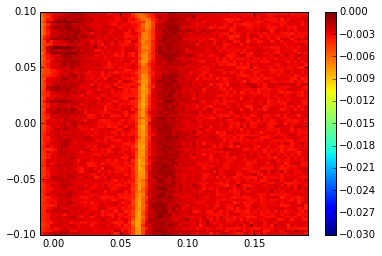

voltage 62.0V


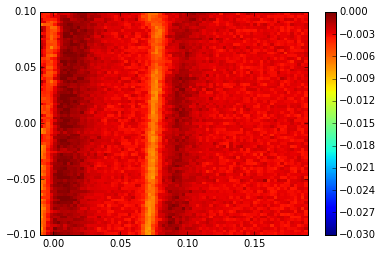

voltage 64.0V


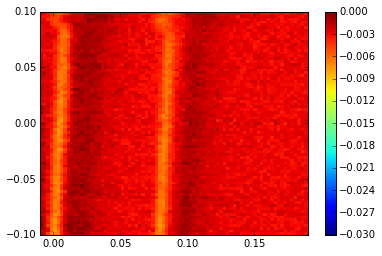

voltage 66.0V


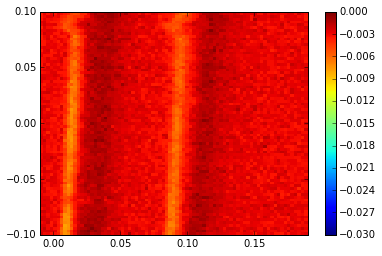

voltage 68.0V


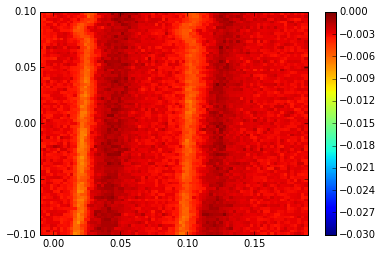

In [13]:
# settings ==================================================
# ===========================================================

roi_initial =  {
        "xo": 0.09, 'yo': 0,
        "dx": 0.2, 'dy': 0.2,
        'xPts': 80, 'yPts': 80
    }



timePerPt = 0.001

voltages = np.arange(40,70,2)

# ony needed if saving data
dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Box_c4_r3_ScanFocus_Beam_6/'

tag = 'Si3Ni4_withPads'



#run script =================================================
# ===========================================================



image_std_dev = []

for counter, voltage in enumerate(voltages):
    
    print 'voltage {:0.1f}V' .format(voltage)
    # set focus
    xController.setVoltage(voltage)

    image_data = acquire_roi_and_show(roi_initial)
    
    image_std_dev.append( [voltage, np.std(image_data)])

    # save image and data
#     save_image_and_data(fig, imageData, dirpath, '{:s}_V_{:02d}'.format(tag, voltage))

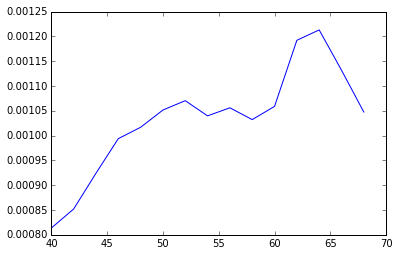

In [14]:
std_dev_data = np.array(image_std_dev)
plt.plot(std_dev_data[:, 0], std_dev_data[:,1])

In [15]:
xController.setVoltage(51)

# scan z and compensate for drifts - not finished!!!

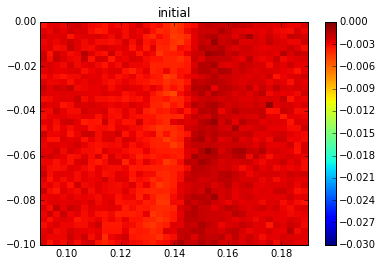

starting
new roi (xo, yo) = (0.140, -0.050)


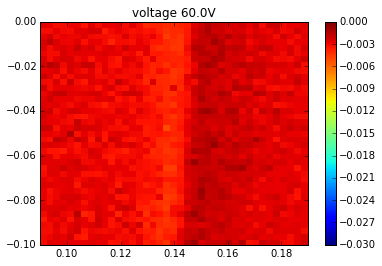

new roi (xo, yo) = (0.141, -0.049)


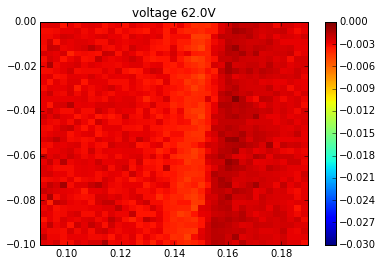

new roi (xo, yo) = (0.142, -0.048)


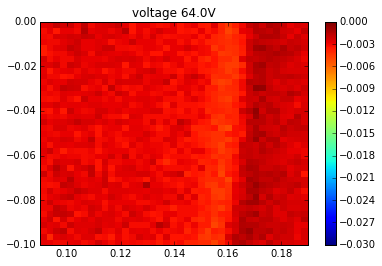

new roi (xo, yo) = (0.142, -0.046)


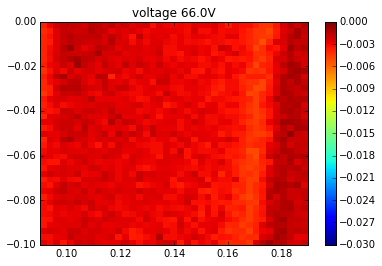

new roi (xo, yo) = (0.141, -0.045)


In [5]:
# settings ==================================================
# ===========================================================

roi_initial = {
        "xo": 0.14, 'yo': -0.05,
        "dx": 0.1, 'dy': 0.1,
        'xPts': 40, 'yPts': 40
    }

timePerPt = 0.001

voltages = np.arange(62,65,5)
voltages = np.array([60, 62, 64, 66])
# ony needed if saving data
dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/Box_c4_r3_ScanFocus_Beam_6/'

tag = 'Si3Ni4_withPads'

xController.setVoltage(voltages[0])

#run script =================================================
# ===========================================================

xController = pc.MDT693A('X')

image_std_dev = []
roi = roi_initial.copy()

image_data = acquire_roi_and_show(roi_initial, 'initial')

print 'starting'
print 'new roi (xo, yo) = ({:0.3f}, {:0.3f})'.format(roi['xo'], roi['yo'])

for counter, voltage in enumerate(voltages):
    image_data_old = image_data
#     print 'voltage {:0.1f}V' .format(voltage)
    # set focus
    xController.setVoltage(voltage)

    image_data = acquire_roi_and_show(roi_initial, 'voltage {:0.1f}V'.format(voltage))
    
    image_std_dev.append( [voltage, np.std(image_data)])
    
    roi.update(track.find_beam_position(image_data_old, image_data, roi))
    
    print 'new roi (xo, yo) = ({:0.3f}, {:0.3f})'.format(roi['xo'], roi['yo'])
    
    # save image and data
#     save_image_and_data(fig, imageData, dirpath, '{:s}_V_{:02d}'.format(tag, voltage))

# playing around

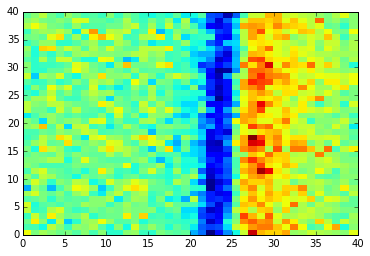

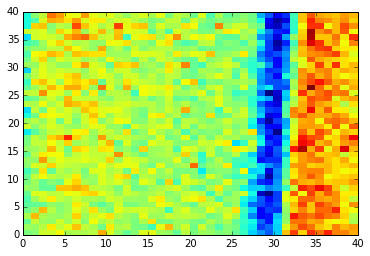

In [15]:
plt.pcolor(image_data_old)
plt.figure()
plt.pcolor(image_data)

19 19
19 19


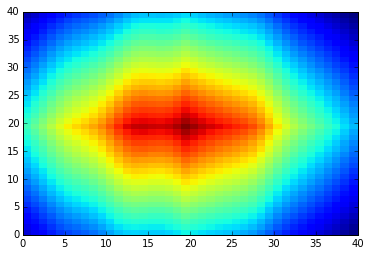

In [17]:
from scipy import signal

cor = signal.correlate2d (image_data_old, image_data_old, mode='same')
initial_max_y, initial_max_x = np.unravel_index(np.argmax(cor),cor.shape)

cor = signal.correlate2d (image_data_old, image_data, mode='same')
max_y, max_x = np.unravel_index(np.argmax(cor),cor.shape)


print max_y, max_x
print initial_max_y, initial_max_x

plt.pcolor(cor)

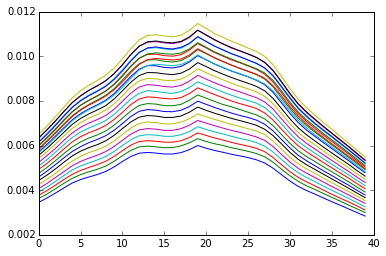

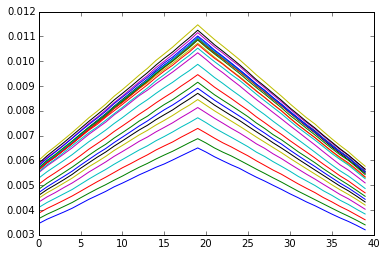

In [25]:
for i in np.arange(25):
    plt.plot(cor[i,:])
plt.figure()
for i in np.arange(25):
    plt.plot(cor[:,i])

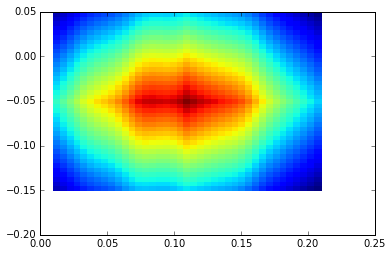

In [61]:
import scipy.optimize as opt
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

x = np.linspace(roi['xo'] - roi['dx'], roi['xo'] + roi['dx'], roi['xPts'])
y = np.linspace(roi['yo'] - roi['dy'], roi['yo'] + roi['dy'], roi['yPts'])
x, y = np.meshgrid(x, y)

initial_guess = (np.max(cor), x[0,max_x], y[max_y,0], roi['dx']/2, roi['dy']/2,0,0)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), cor.flatten(), p0=initial_guess)



plt.pcolor(x, y, cor)

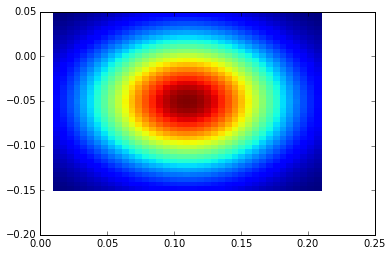

In [62]:
plt.pcolor(x, y, twoD_Gaussian((x,y), *initial_guess).reshape(cor.shape) )

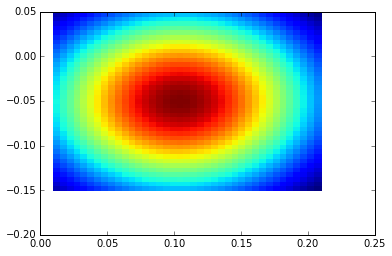

In [63]:
plt.pcolor(x, y, twoD_Gaussian((x,y), *popt).reshape(cor.shape) )

0.101981820839 -0.0522548925134


In [80]:
print popt[1], popt[2]
print initial_guess[1], initial_guess[2]
print roi['xo'], roi['yo']

0.101981820839 -0.0522548925134
0.107435897436 -0.0525641025641
0.11 -0.05


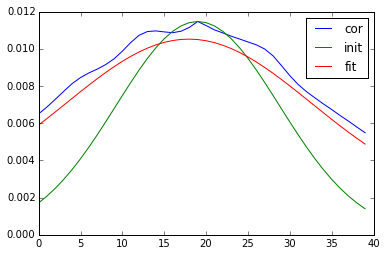

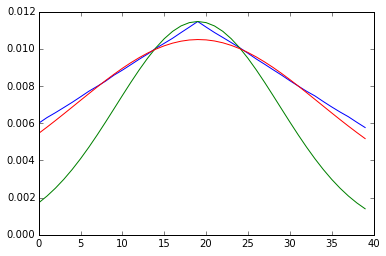

In [72]:
i = 19
fit = twoD_Gaussian((x,y), *popt).reshape(cor.shape) 
init = twoD_Gaussian((x,y), *initial_guess).reshape(cor.shape) 
plt.plot(cor[i,:], label = 'cor')
plt.plot(init[i,:], label = 'init')
plt.plot(fit[i,:], label = 'fit')
plt.legend(loc = 0)
plt.figure()
plt.plot(cor[:,i])
plt.plot(init[:,i])
plt.plot(fit[:,i])